# Data Assimilation workflow revision

## Dependencies

In [35]:
import pandas as pd
import geopandas as gpd
import shapely
import datetime
from pyproj import Transformer

import os
import warnings

In [69]:
def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, alpha=0.1, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = alpha, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')

def reproject_geom(geom, from_crs='EPSG:5070', to_crs='EPSG:3857'):
    return gpd.GeoSeries(geom, crs=from_crs).to_crs(to_crs)[0]

def get_wind_params(tix : int):
    wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
    wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

    return wslst[tix], wdlst[tix]

def get_observation(description : str, tix : int):
    ''' Obtain selected observation geometry and datetime
    '''

    if description not in ['Maria2019', 'River2021', 'Bridge2021']:
        raise ValueError(f'description {description} not present in db')
    
    def change_username_jovyan(df, column):
        for ix, row in df.iterrows():
            path_list = row[column].split('/')
            path_list[2] = 'jovyan'
    
            path = ''
            for string in path_list[:-1]:
                path += f'{string}/'
            path += path_list[-1]
    
            df.loc[ix, column] = path  
    
    df = pd.read_pickle('/home/jovyan/data/dftable_06032023.pkl')
    change_username_jovyan(df, 'filepath')
    
    dfrow = df[df['description'] == description].sort_values('datetime').iloc[tix]
    dfgeom = gpd.read_file(dfrow['filepath'])['geometry'][0]
    dfdt = dfrow['datetime']
    
    return dfgeom, dfdt

## Mock use of the Data Assimilation Workflow

1. Start with an ignition (or an initial perimeter)
2. Calculate 30-minute interval FARSITE simulations
3. Time passes until the next aircraft perimeter
4. Use data assimilation to update the 30-minute intervals

In [129]:
description = 'Maria2019'
tix = 0

def get_wind_params(tix : int):
    wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
    wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

    return wslst[tix], wdlst[tix]

def get_observation(description : str, tix : int):
    ''' Obtain selected observation geometry and datetime
    '''

    if description not in ['Maria2019', 'River2021', 'Bridge2021']:
        raise ValueError(f'description {description} not present in db')
    
    def change_username_jovyan(df, column):
        for ix, row in df.iterrows():
            path_list = row[column].split('/')
            path_list[2] = 'jovyan'
    
            path = ''
            for string in path_list[:-1]:
                path += f'{string}/'
            path += path_list[-1]
    
            df.loc[ix, column] = path  
    
    df = pd.read_pickle('/home/jovyan/data/dftable_06032023.pkl')
    change_username_jovyan(df, 'filepath')
    
    dfrow = df[df['description'] == description].sort_values('datetime').iloc[tix]
    dfgeom = gpd.read_file(dfrow['filepath'])['geometry'][0]
    dfdt = dfrow['datetime']
    
    return dfgeom, dfdt

def create_landscape(id, lat, lon):
    warnings.warn('Only points to one of three lcp selections: Maria, Bridge or River. Need to get connection to hotshot server')
    return '/home/jovyan/farsite/inputs/landscapes/Maria2019.lcp'
    # transformer = Transformer.from_crs("EPSG:4326", "EPSG:5070")
    # x, y = transformer.transform(lat, lon)
    
    # ulx = x-10000
    # uly = y+10000
    # lrx = x+10000
    # lry=  y-10000

    # fname_lst = {'density': 'US_140CBD_12052016/Grid/us_140cbd', 
    #              'base': 'US_140CBH_12052016/Grid/us_140cbh', 
    #              'cover': 'US_140CC_12052016/Grid/us_140cc', 
    #              'height': 'US_140CH_12052016/Grid/us_140ch', 
    #              'fuel': 'US_140FBFM40_20180618/Grid/us_140fbfm40', 
    #              'aspect': 'Aspect/Grid/us_asp', 
    #              'elevation': 'DEM_Elevation/Grid/us_dem', 
    #              'slope': 'Slope/Grid/us_slp'}
    # type_lst = {'density': 'cbd',
    #             'base': 'cbh',
    #             'cover': 'cc',
    #             'height': 'ch',
    #             'fuel': 'fuel',   # fbfm40
    #             'aspect': 'aspect',
    #             'elevation': 'elevation', #dem
    #             'slope': 'slope'}

    # from_folder = os.path.join('/data', 'firemap', 'landfire', 'mosaic')
    # to_folder = '/home/jovyan/farsite/inputs/landscapes/'

    # # Create the asc files
    # ascpath_lst = {}
    # for (key, fname) in fname_lst.items():
    #     ascpath_lst[key] = f'{os.path.join(to_folder, id)}-{key}.asc'
    #     os.system(f'gdal_translate -of AAIGrid -a_nodata -32768 -projwin {ulx} {uly} {lrx} {lry} {os.path.join(from_folder, fname)} {ascpath_lst[key]}')
        
    # lcppath = f'{os.path.join(to_folder, id)}'
    # lcpmakepath = '/home/jovyan/farsite/src/lcpmake'

    # base_command = f'{lcpmakepath} -latitude {lat} -landscape {lcppath}'
    # run_command = base_command
    # for (key, ascpath) in ascpath_lst.items():
    #     run_command += f' -{key} {ascpath}'

    # os.system(run_command)
    
    # os.system(f"rm {os.path.join(to_folder, '*asc')}  {os.path.join(to_folder, '*prj')} {os.path.join(to_folder, '*xml')}")
    
    # return lcppath

def forward_pass(poly, params):
    '''
        params: take values: 'windspeed', 'winddirection' ,'dt' (dt is a datetime.timedelta object)
    '''
    # Parameters to run the simulation
    windspeed = params['windspeed']
    winddirection = params['winddirection']
    dt = params['dt']
    
    # Create handles for simulation
    fp = futils.FilePaths(DATA_PATH)
    usr = futils.User(fp)

    initialidx = uuid.uuid4().hex
    fpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{initialidx}.shp'
    # Creating the shp file for simulation
    gpd.GeoDataFrame({'FID': [0], 'geometry':poly}, crs='EPSG:5070').to_file(fpath)
    
    usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation', 
                                                                                               fpath, datetime.datetime.now(),
                                                                                               'Maria2019']
    
    observeidx = uuid.uuid4().hex
    # Add observationidx only to calculate the dt in the backend
    usr.db.dfObservation.loc[observeidx, 'datetime'] = usr.db.dfObservation.loc[initialidx, 'datetime'] + dt
    
    
    # Run simulation for dt from initialidx
    calculate(initialidx, observeidx, windspeed, winddirection, usr)
    
    # add simulation as the next initial point
    dfsim = usr.db.dfsimulation[(usr.db.dfsimulation['igniteidx'] == initialidx) & 
                            (usr.db.dfsimulation['compareidx'] == observeidx)]
    
    if len(dfsim) < 1:
        return None
    
    # assert(len(dfsim) == 1) , f'Length of dfsim = {len(dfsim)}'
    if len(dfsim) != 1:
        raise ValueError(f'Length of dfsim = {len(dfsim)}')

    usr.db.dfObservation.loc[dfsim.index[0], ['filetype', 'description']] = ['Observation', 'Maria2019']
    

    simpath = f'/home/jovyan/farsite/inputs/maria_ignite/Reference/maria_{observeidx}.shp'
    dfgeom = gpd.read_file(dfsim['filepath'].iloc[0])['geometry']
    assert(len(dfgeom) == 1), f'dfgeom has size = {len(dfgeom)}'
    dfgeom = dfgeom[0]
    return Polygon(dfgeom.coords)

In [90]:
import contextily as ctx
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

In [85]:
gpd.read_file('/home/jovyan/farsite/inputs/maria_ignite/

1504505.2519616494

## Start with first timepoint

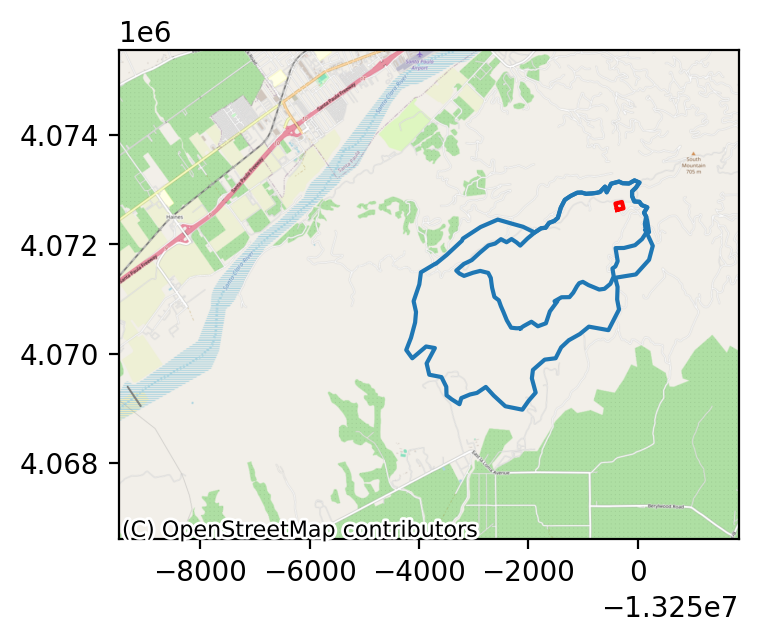

In [121]:
geom, dt = get_observation('Maria2019', 0)
geom1, dt1 = get_observation('Maria2019', 1)

cx = geom.centroid.xy[0][0] + 1000
cy = geom.centroid.xy[1][0] + 500
size = 100
ignition = Polygon(((cx-size/2,cy-size/2), (cx-size/2,cy+size/2), (cx+size/2,cy+size/2), (cx+size/2, cy-size/2)))

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(geom), ax=ax)
plot_geometry(reproject_geom(ignition), ax=ax, color='red')
plot_geometry(reproject_geom(geom1), ax=ax, color='tab:blue')

ax.set_xlim((-13259490.671518039, -13248150.849562285))
ax.set_ylim((4066608.972659642, 4075555.258855688))

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

NameError: name 'futils' is not defined

In [6]:
class FilePaths:
    def __init__(self, datadir):
        self.datadir = datadir
        self.dfpath = os.path.join(self.datadir, 'dftable_06032023.pkl')
    
    def create_rundir(self):
        dtdir = datetime.datetime.now().strftime('%Y%m%d')
        self.basedir = os.path.join(self.datadir, dtdir)
        
        # If dtdir does not exist, make one
        if not os.path.isdir(self.basedir):
            os.mkdir(self.basedir)
        
        # Find the non-existing folder
        isdirfound = False
        for cnt in range(100000):
            rundir = os.path.join(self.basedir, 'Run_{:05d}'.format(cnt))
            if not os.path.isdir(rundir):
                isdirfound = True
                break
        
        if isdirfound:
            os.mkdir(rundir)
            return rundir
        
        print('Max iteration reached! {}. No empty dir found'.format(cnt))

def change_username_jovyan(df, column):
    for ix, row in df.iterrows():
        path_list = row[column].split('/')
        path_list[2] = 'jovyan'

        path = ''
        for string in path_list[:-1]:
            path += f'{string}/'
        path += path_list[-1]

        df.loc[ix, column] = path        

        
class Database_v2:
    def __init__(self, fp: FilePaths):
        # Setup params
        self.fp = fp
        
        # TODO
        # Setup the database for reading
        
        
        try:
            dftable = pd.read_pickle(self.fp.dfpath)
            change_username_jovyan(dftable, 'filepath')
        except FileNotFoundError:
            print(f'\n!!Caution!! Path {self.fp.dfpath} not found! Cannot choose ignition!!\n')
            raise
            
        # Collect the tables in dataframe format
        # Table 1 - ignition
        self.dfObservationAll = dftable[dftable['filetype'] == 'Observation']
        
        # Table 2 - barrier
        self.dfBarrier = dftable[dftable['filetype'] == 'Barrier'][['filetype', 'filepath']]
        # Table 3 - landscape
        self.dfLandscapeAll = dftable[dftable['filetype'] == 'Landscape'][['filetype', 'filepath', 'description']]
        # Table 4 - simulation
        self.dfsimulation = pd.DataFrame()
        
        self.filter_selection('Maria2019')
        
    def filter_selection(self, description):
        self.dfObservation = self.dfObservationAll[self.dfObservationAll['description'] == description]
        self.dfLandscape = self.dfLandscapeAll[self.dfLandscapeAll['description'] == description]
        
    def create_rundir(self):
        return self.fp.create_rundir()    
    
    def lcppath(self, lcpidx):
        return self.dfLandscape.loc[lcpidx, 'filepath']
    def observepath(self, igniteidx):
        return self.dfObservation.loc[igniteidx, 'filepath']
    def barrierpath(self, barrieridx):
        return self.dfBarrier.loc[barrieridx, 'filepath']
    
    def append(self, data: dict):
        filetype = data['filetype']
        
        if filetype == 'Simulation':
            # Read the output simulation geoms
            if os.path.exists(data['filepath']):
                gdf = gpd.read_file(data['filepath'])
                idxlst = []
                geomlst = []
                igniteidxlst = []
                compareidxlst = []
                descriptionlst = []
                datetimelst = []
                filepathlst = []
                windspeedlst = []
                winddirectionlst = []
                configpathlst = []

                # For each elapsed time
                minuteslst = gdf['Elapsed_Mi'].unique()

                for minutespassed in minuteslst:
                    gdf0 = gdf[gdf['Elapsed_Mi'] == minutespassed]
                    polygon_lst = [Polygon(value) for value in gdf0['geometry'].values]
                    multipoly = MultiPolygon()
                    for poly in polygon_lst:
                        multipoly = multipoly.union(poly.buffer(0))
                    geomlst.append(multipoly)

                    # unique id
                    uniqueid = uuid.uuid4().hex
                    idxlst.append(uniqueid)

                    igniteidxlst.append(data['igniteidx'])
                    compareidxlst.append(data['compareidx'])
                    descriptionlst.append(data['description'])
                    datetimelst.append(data['startdt'] + datetime.timedelta(minutes=minutespassed))
                    filepathlst.append(data['filepath'])
                    windspeedlst.append(data['windspeed'])
                    winddirectionlst.append(data['winddirection'])
                    configpathlst.append(data['configpath'])

                # Create the gdf for appending
                dfappend = pd.DataFrame({'igniteidx': igniteidxlst,
                                              'compareidx': compareidxlst,
                                              'description': descriptionlst,
                                              'datetime': datetimelst,
                                              'filepath': filepathlst,
                                              'windspeed': windspeedlst,
                                              'winddirection': winddirectionlst,
                                              'configpath': configpathlst},
                                         index=idxlst)
                self.dfsimulation = pd.concat([self.dfsimulation,
                                                dfappend])
        else:
            print(f'filetype = {filetype} not yet implemented!')

In [ ]:
Database_v2(

In [ ]:
def select_ignition(geometry, timestamp):
    '''
        
    '''